https://learnopencv.com/variational-autoencoder-in-tensorflow/

In [1]:
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import numpy as np

import matplotlib.pyplot as plt

from IPython import display

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3).astype('float32')
x_test = x_test.astype('float32')

In [4]:
# x_train = x_train / 255. # normalized later
x_test = x_test / 255.

Batch and shuffle the data

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128)

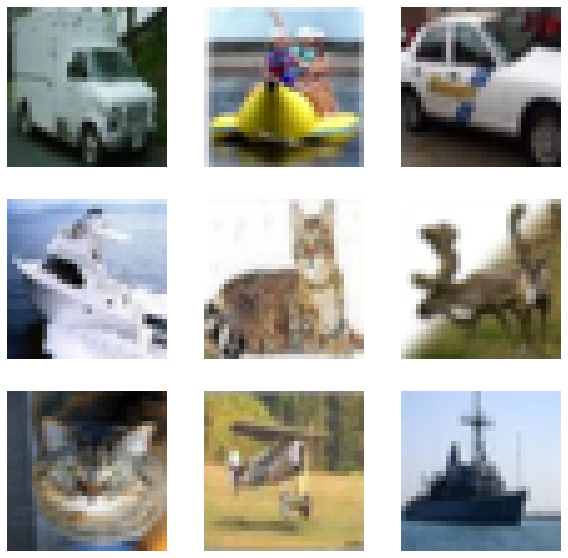

In [6]:
plt.figure(figsize=(10,10))
for images in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i, :, :, :].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale=1./255)

In [8]:
normalized_ds = train_dataset.map(lambda x: normalization_layer(x))

In [9]:
image_batch = next(iter(normalized_ds))

In [10]:
first_image = image_batch[0]

In [11]:
input_encoder = (32, 32, 3)
input_decoder = (2,)

In [12]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0.0, stddev=1.0)
    print(epsilon)
    return mean + K.exp(log_var / 2) * epsilon

In [13]:
sampling_model

<function __main__.sampling_model>

In [14]:
def encoder(input_encoder):
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    flatten = layers.Flatten()(x)
    mean = layers.Dense(2, name='mean')(flatten)
    log_var = layers.Dense(2, name='log_var')(flatten)
    
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [15]:
enc = encoder(input_encoder)
# enc.save

In [16]:
enc.output

(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'mean')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'log_var')>)

In [17]:
input_1 = (2,)
input_2 = (2,)

In [18]:
def sampling(input_1, input_2):
    mean = keras.Input(shape=input_1, name="input_layer1")
    log_var = keras.Input(shape=input_2, name="input_layer2")
    out = layers.Lambda(sampling_model, name="encoder_output")([mean, log_var])
    enc_2 = tf.keras.Model([mean, log_var], out, name="Encoder_2")
    return enc_2

In [19]:
final = sampling(input_1, input_2)
# final.save

Tensor("encoder_output/random_normal:0", shape=(None, 2), dtype=float32)


In [20]:
def decoder(input_decoder):
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs) # Check values
    x = tf.reshape(x, [-1, 8, 8, 64], name='Reshape_Layer') # Check values
    
    # Block 1
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    # Block 2
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    # Block 4
    outputs = layers.Conv2DTranspose(3, 3, 1, padding='same', activation='sigmoid', name='conv_transpose_4')(x)
    
    model = tf.keras.Model(inputs, outputs, name="Decoder")    
    return model

In [21]:
dec = decoder(input_decoder)
# dec.save

Optimizer and Loss Function

In [22]:
optimizer = tf.keras.optimizers.Adam(lr=5e-4)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis=[1,2,3])
    return 1000 * r_loss

In [24]:
def kl_loss(mean, log_var):
    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss

In [25]:
def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl__loss = kl_loss(mean, log_var)
    return r_loss + kl__loss

In [26]:
# Notice the use ot 'tf.function'
# This annotation causes the function to be "compiled"
@tf.function
def train_step(images):
    
    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)
        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    
    return loss

In [27]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_images([enc, final, dec], epoch + 1, seed)
        # enc.save_weights
        # dec.save_weights
        print(f'Time for epoch {epoch+1} is {time.time()-start} sec')
        
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_images([enc, final, dec], epochs, seed)

In [28]:
def generate_images(model, epoch, test_input):
    # Training is set to 'False' so all layers run in inference mode (batchnorm)
    m, v = enc(test_input, training=False)
    latent = final([m, v])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, 1+i)
        plt.imshow((predictions[i, :, :, :]*255).numpy().astype("uint8"))
        plt.axis("off")
        
    # plt.savefig
    plt.show()

tf.Tensor(
[[-0.44866335 -0.59622145]
 [-1.2142009  -0.00402504]
 [ 1.5570536  -0.53230536]
 [ 1.550969   -1.3985533 ]
 [-0.95955944 -0.76240337]
 [ 0.23291464  0.06090382]
 [-0.46686757  0.6682453 ]
 [ 0.03628771 -1.593332  ]
 [ 0.1587844  -0.4868812 ]
 [-0.32980213 -1.5521932 ]
 [-0.443077    0.7437171 ]
 [ 1.7632171  -0.35918257]
 [-0.28222033  0.03129052]
 [ 1.194862    0.04188465]
 [-1.4456893  -0.13311574]
 [-1.0276028  -0.8933013 ]
 [-0.9336751   2.6505203 ]
 [ 0.61124176 -1.0687104 ]
 [-1.5051409   0.6644735 ]
 [-0.12466524  0.42240956]
 [-2.43808    -0.5762832 ]
 [-1.4907656   0.67999136]
 [-0.48108852 -0.14618108]
 [-0.6639418  -0.5807826 ]
 [-1.163574    1.6831342 ]], shape=(25, 2), dtype=float32)
(25, 32, 32, 3)


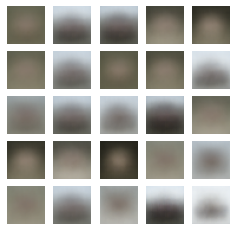

In [29]:
train(normalized_ds, 100)

Visualize the Latent Space

In [30]:
imgs_vizualize = 5000
figsize = 10

In [31]:
index = np.random.choice(range(len(x_test)), imgs_vizualize)
images = x_test[index]

In [32]:
m, v = enc.predict(images)
embeddings = final([m, v])

tf.Tensor(
[[-0.7387957  -0.0672767 ]
 [ 0.60308176 -1.4046396 ]
 [ 0.08423925 -0.21639957]
 ...
 [ 1.3743845   0.9481602 ]
 [-0.6465599   1.1604337 ]
 [ 1.0018934  -1.0634183 ]], shape=(5000, 2), dtype=float32)


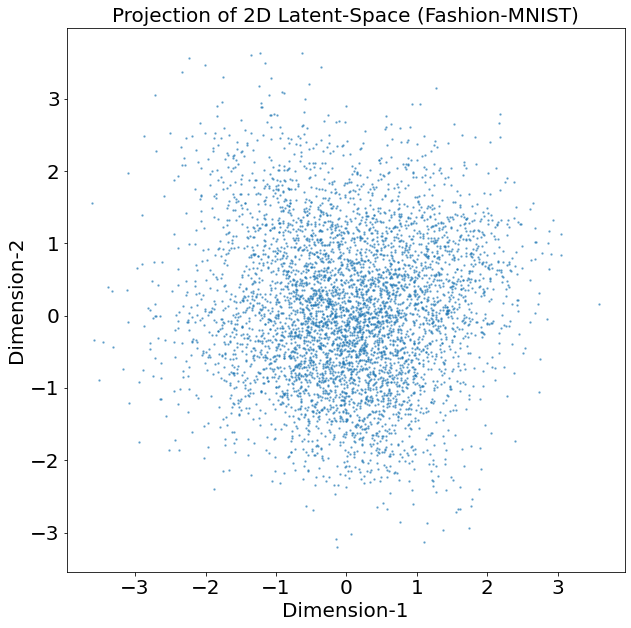

In [33]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space (Fashion-MNIST)", size=20)
plt.show()

Reconstructing Fashion Images with Latent-Vector Sampled Uniformly

In [34]:
min_x = min(embeddings[:, 0])
max_x = max(embeddings[:, 0])
min_y = min(embeddings[:, 1])
max_y = max(embeddings[:, 1])

In [35]:
x = np.random.uniform(low=min_x,high=max_x, size = (10,1))
y = np.random.uniform(low=min_y,high=max_y, size = (10,1))

In [36]:
bottleneck = np.concatenate((x, y), axis=1)

In [37]:
reconst = dec.predict(bottleneck)

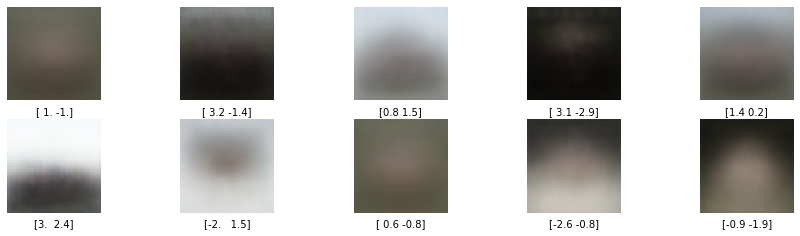

In [38]:
fig = plt.figure(figsize=(15, 10))
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(np.round(bottleneck[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,:])